In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

store = pd.HDFStore('../../data/processed/orbf_benin.h5')
data = store['data']
store.close()

In [3]:
indicators = ['Accouchement eutocique assiste',
       'CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments)',
       'Consultation prenatale quatrieme visite standard',
       'Diagnostic et traitement des cas de paludisme grave chez les femmes enceintes',
       'Diagnostic et traitement des cas de paludisme simple chez les enfants',
       'Diagnostic et traitement des cas de paludisme simple chez les femmes enceintes',
       'Diagnostic et traitement des cas de paludisme sévère chez les enfants',
       'Enfants completement vaccines',
       "Nombre d'enfants ayant reçu le Penta 3",
       'Vaccination au BCG']

In [24]:
data_to_desc = data[['entity_name', 'entity_type' , 'indicator_label', 'indicator_verified_value' , 'date' , 'geozone_name' , 'parent_geozone_name']]
data_to_desc = data_to_desc[~(data_to_desc['entity_name'].isin(['Aklampa Cs' , 'Dispensaire Isolé De Houndjava  Di' , 'Houedomey Csc' , 'Ouesse Csc' ]))]
data_to_desc['id_zone_type'] = data_to_desc.entity_type + '_' + data_to_desc.geozone_name

In [25]:
def pivot_data(data):
    try :
        data = data.pivot(index='date', columns='indicator_label', values='indicator_verified_value')
    except ValueError :
        print(data.entity_name)
    return data

a = data_to_desc.groupby(['entity_name' , 'entity_type' , 'id_zone_type' , 'geozone_name' , 'parent_geozone_name']).apply(pivot_data)
a = a.fillna(0)
a = a.groupby(level = [0,1,2,3,4]).apply(axis = 0 , func = np.mean)
a = a.reset_index(drop = False)

In [26]:
dat = a

In [27]:
X = a[indicators]
drop = list(X.apply(axis = 1 , func = np.median) > 0)
X = X[drop].reset_index(drop = True)

entity_type_list = a.parent_geozone_name[drop].reset_index(drop = True)
entity_type_names = entity_type_list.unique()

#entity_name_list = a.entity_name[drop].reset_index()
#entity_names = y.unique()

In [28]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [29]:
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

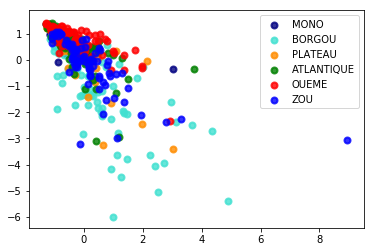

In [30]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange' , 'green' , 'red' , 'blue' ,'yellow']
lw = 2

for color, entity_type  in zip(colors, entity_type_names):
    xp = max(Y_sklearn[ entity_type_list[entity_type_list == entity_type].index, 1])
    if xp < 10 :
        plt.scatter(Y_sklearn[ entity_type_list[entity_type_list == entity_type].index, 0], Y_sklearn[ entity_type_list[entity_type_list == entity_type].index , 1], color=color, alpha=.8, lw=lw,
                label=entity_type)
plt.legend(loc='best', shadow=False, scatterpoints=1)

In [31]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage='ward', compute_full_tree=True).fit(Y_sklearn)
ward

AgglomerativeClustering(affinity='euclidean', compute_full_tree=True,
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=2,
            pooling_func=<function mean at 0x000000C775DB2598>)

In [32]:
X.apply(axis = 0 , func = np.median)

Accouchement eutocique assiste                                                    14.557174
CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments)         8.375000
Consultation prenatale quatrieme visite standard                                   4.911341
Diagnostic et traitement des cas de paludisme grave chez les femmes enceintes      0.083333
Diagnostic et traitement des cas de paludisme simple chez les enfants             24.583333
Diagnostic et traitement des cas de paludisme simple chez les femmes enceintes     4.187719
Diagnostic et traitement des cas de paludisme sévère chez les enfants              0.333333
Enfants completement vaccines                                                     19.041667
Nombre d'enfants ayant reçu le Penta 3                                            17.500000
Vaccination au BCG                                                                18.931579
dtype: float64

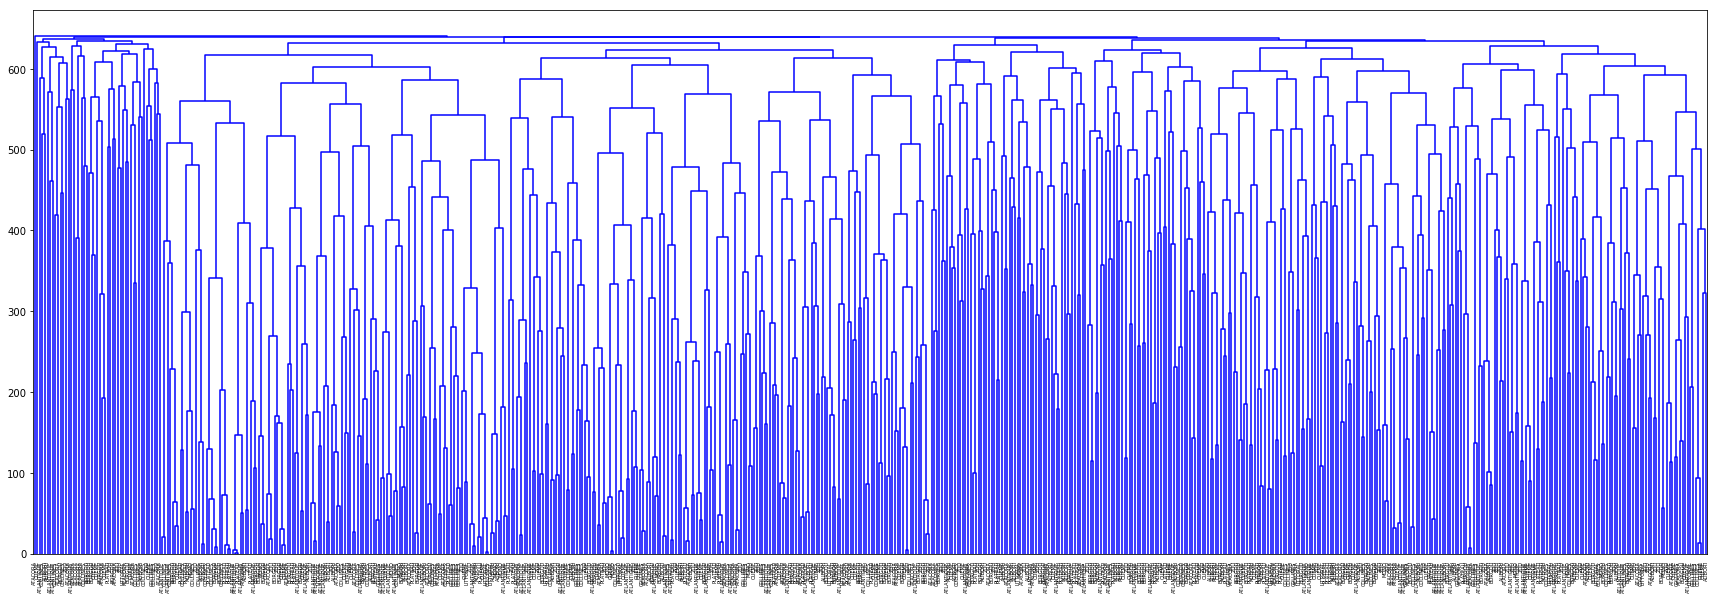

In [34]:
from scipy.cluster.hierarchy import dendrogram

dendro = [ ]
for a,b in ward.children_:
    dendro.append([a,b,float(len(dendro)+1),len(dendro)+1])
    # le dernier coefficient devrait contenir le nombre de feuilles dépendant de ce noeud
    # et non le dernier indice
    # de même, le niveau (3ème colonne) ne devrait pas être le nombre de noeud
    # mais la distance de Ward

fig = plt.figure( figsize=(30,10) )
ax = fig.add_subplot(1,1,1)
r = dendrogram(dendro, color_threshold=1, labels=list(dat.parent_geozone_name) , show_leaf_counts=False, ax=ax, orientation = "top")